In [13]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import time

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

plt.rcParams['figure.facecolor'] = '#ffffff'


In [14]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 30

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
device = torch.device('cuda:0')
GRAYSCALE = False


In [15]:
transform = transforms.Compose([ 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
])

In [16]:
data_dir = './data/cifar10'

train_indices = torch.arange(0, 49000)
valid_indices = torch.arange(49000, 50000)

train_and_valid = datasets.CIFAR10(root=data_dir, 
                                   train=True, 
                                   transform=transform,
                                   download=False)
train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

test_dataset = datasets.CIFAR10(root=data_dir, 
                                train=False, 
                                transform=transform)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [17]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

In [18]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # 3x3
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 1x1
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


In [19]:
class ResNet(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [20]:
torch.manual_seed(RANDOM_SEED)

model = ResNet18()

model.to(device)



ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [21]:
lr = LEARNING_RATE
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)


In [22]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        outputs = model(features)
        _, predicted_labels = torch.max(outputs, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

loss_train_epoch_arr = []

acc_train_epoch_arr = []
acc_val_epoch_arr = []

def train(epoch):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 120:
            print (f'Epoch: {epoch+1:d}/{NUM_EPOCHS:d} | '
                   f'Batch {batch_idx:d}/{len(train_loader):d} |' 
                   f' Loss: {loss:.4f}')
            
    loss_train_epoch_arr.append(loss.item())
    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc = compute_accuracy(model, train_loader, device=device)
        valid_acc = compute_accuracy(model, valid_loader, device=device)
        acc_train_epoch_arr.append(train_acc.item())
        acc_val_epoch_arr.append(valid_acc.item())
        print(f'Epoch: {epoch+1:d}/{NUM_EPOCHS:d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

In [23]:
load_model = True
if load_model:
    checkpoint = torch.load('./model/res18_sgd.ckpt')
    model.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 29


In [32]:
start_time = time.time()
for epoch in range(start_epoch, NUM_EPOCHS):
    train(epoch)

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 25/30 | Batch 0/383 | Loss: 0.0579
Epoch: 25/30 | Batch 120/383 | Loss: 0.0648
Epoch: 25/30 | Batch 240/383 | Loss: 0.0684
Epoch: 25/30 | Batch 360/383 | Loss: 0.0857
Epoch: 25/30 Train Acc.: 97.67% | Validation Acc.: 81.40%
Time elapsed: 1.97 min
Epoch: 26/30 | Batch 0/383 | Loss: 0.0527
Epoch: 26/30 | Batch 120/383 | Loss: 0.0455
Epoch: 26/30 | Batch 240/383 | Loss: 0.0991
Epoch: 26/30 | Batch 360/383 | Loss: 0.0679
Epoch: 26/30 Train Acc.: 97.81% | Validation Acc.: 80.70%
Time elapsed: 3.94 min
Epoch: 27/30 | Batch 0/383 | Loss: 0.0939
Epoch: 27/30 | Batch 120/383 | Loss: 0.0373
Epoch: 27/30 | Batch 240/383 | Loss: 0.0742
Epoch: 27/30 | Batch 360/383 | Loss: 0.1077
Epoch: 27/30 Train Acc.: 97.61% | Validation Acc.: 80.30%
Time elapsed: 5.90 min
Epoch: 28/30 | Batch 0/383 | Loss: 0.0335
Epoch: 28/30 | Batch 120/383 | Loss: 0.0219
Epoch: 28/30 | Batch 240/383 | Loss: 0.0735
Epoch: 28/30 | Batch 360/383 | Loss: 0.0917
Epoch: 28/30 Train Acc.: 97.04% | Validation Acc.: 81.50%
Tim

In [33]:
save_model = True
if save_model:
    state = {
        'net': model.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('model', exist_ok=True)
    torch.save(state, './model/res18_adam.ckpt')

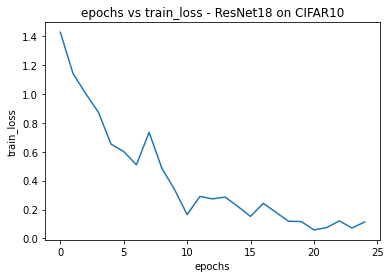

In [14]:
# draw plot
from matplotlib.pyplot import MultipleLocator

plt.plot(loss_train_epoch_arr)
plt.xlabel("epochs")
plt.ylabel("train_loss")
plt.title("epochs vs train_loss - ResNet18 on CIFAR10")
plt.show()

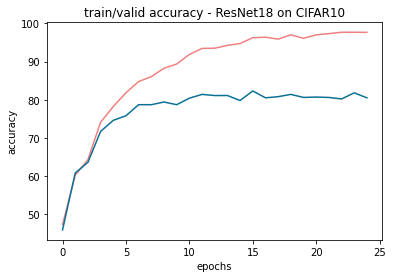

In [15]:
plt.plot(acc_train_epoch_arr,color="#F08080")
plt.plot(acc_val_epoch_arr,color="#0B7093")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train/valid accuracy - ResNet18 on CIFAR10")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


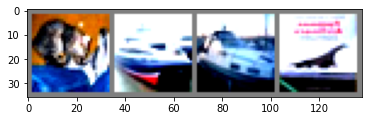

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship horse plane
Accuracy of the network on the 10000 test images: 81.54 %
Accuracy of plane : 72 %
Accuracy of   car : 89 %
Accuracy of  bird : 66 %
Accuracy of   cat : 64 %
Accuracy of  deer : 74 %
Accuracy of   dog : 78 %
Accuracy of  frog : 86 %
Accuracy of horse : 88 %
Accuracy of  ship : 93 %
Accuracy of truck : 87 %


In [24]:
# test
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = model(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))